In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.utils import to_categorical

import os
current_dir = os.getcwd()
%matplotlib inline

/home/joydeb/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/joydeb/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/joydeb/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/joydeb/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

In [2]:
class DataPreparation():
    def __init__(self):
        self.data = None
        self.x_train = None
        self.y_train = None
        self.x_test = None
        self.y_test = None
        self.num_classes = None
        
        
    def load_data(self):
        (self.x_train, self.y_train), (self.x_test, self.y_test) = tf.keras.datasets.mnist.load_data(path=os.path.join(current_dir,'data','mnist.npz'))

    '''
    In Keras, the layers used for two-dimensional convolutions expect pixel values with the dimensions 
    [pixels][width][height][channels].
    We’ll use the .reshape() method to perform this action. 
    Finally, normalize the image data by dividing each pixel value by 255.
    (since RGB value can range from 0 to 255)
    reshape to be [samples][width][height][channels]
    
    we need to convert the dependent variable in the form of integers to a binary class matrix. 
    This can be achieved by the to_categorical() function

    '''    
    def reshape_data(self):
        img_rows, img_cols = 28, 28
        print("Before: ")
        print(self.x_train.shape)
        print(self.x_test.shape)
        self.x_train = self.x_train.reshape(self.x_train.shape[0],img_rows,img_cols,1).astype('float32')
        self.x_test = self.x_test.reshape(self.x_test.shape[0],img_rows,img_cols,1).astype('float32')
        self.x_train /= 255
        self.x_test /= 255
        print("After: ")
        print(self.x_train.shape)
        print(self.x_test.shape)
        self.y_train = to_categorical(self.y_train)
        self.y_test = to_categorical(self.y_test)
        self.num_classes = self.y_test.shape[1]
        print(self.num_classes)
        

In [3]:
dp_obj = DataPreparation()     
dp_obj.load_data()
dp_obj.reshape_data()

Before: 
(60000, 28, 28)
(10000, 28, 28)
After: 
(60000, 28, 28, 1)
(10000, 28, 28, 1)
10


1. The first hidden layer is a convolutional layer called a Convolution2D. The layer has 32 feature maps, which with the size of 5×5 and a rectifier activation function. This is the input layer, expecting images with the structure outline above [pixels][width][height].
2. Next we define a pooling layer that takes the max called MaxPooling2D. It is configured with a pool size of 2×2.
3. The next layer is a regularization layer using dropout called Dropout. It is configured to randomly exclude 20% of neurons in the layer in order to reduce overfitting.
4. Next is a layer that converts the 2D matrix data to a vector called Flatten. It allows the output to be processed by standard fully connected layers.
5. Next a fully connected layer with 128 neurons and rectifier activation function.
6. Finally, the output layer has 10 neurons for the 10 classes and a softmax activation function to output probability-like predictions for each class.

In [18]:
class ModelDesign():
    def __init__(self):
        self.model = None
        self.num_classes = dp_obj.num_classes
        self.history = None
        
    def base_model(self):
        self.model = Sequential()
        self.model.add(Conv2D(32,(5,5),activation='relu'))
        self.model.add(MaxPooling2D(pool_size=(2,2)))
        self.model.add(Dropout(0.2))
        self.model.add(Flatten())
        self.model.add(Dense(self.num_classes,activation="softmax"))
        
    def compile_model(self):
        self.model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
    
    def train_model(self,batch_size,epochs):
        x_train = dp_obj.x_train
        y_train = dp_obj.y_train
        x_test = dp_obj.x_test
        y_test = dp_obj.y_test
        #model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)
        
        self.history = self.model.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, verbose=2, validation_data = (x_test,y_test),shuffle=True)

In [19]:
epochs = 10
batch_size = 128

md_obj = ModelDesign()
md_obj.base_model()
md_obj.compile_model()
md_obj.train_model(batch_size,epochs)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 - 9s - loss: 0.3101 - acc: 0.9139 - val_loss: 0.1233 - val_acc: 0.9654
Epoch 2/10
60000/60000 - 10s - loss: 0.1072 - acc: 0.9696 - val_loss: 0.0752 - val_acc: 0.9772
Epoch 3/10
60000/60000 - 10s - loss: 0.0777 - acc: 0.9775 - val_loss: 0.0594 - val_acc: 0.9809
Epoch 4/10
60000/60000 - 10s - loss: 0.0621 - acc: 0.9815 - val_loss: 0.0546 - val_acc: 0.9823
Epoch 5/10
60000/60000 - 10s - loss: 0.0553 - acc: 0.9837 - val_loss: 0.0441 - val_acc: 0.9855
Epoch 6/10
60000/60000 - 10s - loss: 0.0505 - acc: 0.9848 - val_loss: 0.0448 - val_acc: 0.9843
Epoch 7/10
60000/60000 - 10s - loss: 0.0442 - acc: 0.9864 - val_loss: 0.0434 - val_acc: 0.9850
Epoch 8/10
60000/60000 - 10s - loss: 0.0404 - acc: 0.9879 - val_loss: 0.0445 - val_acc: 0.9851
Epoch 9/10
60000/60000 - 10s - loss: 0.0367 - acc: 0.9884 - val_loss: 0.0435 - val_acc: 0.9860
Epoch 10/10
60000/60000 - 10s - loss: 0.0340 - acc: 0.9897 - val_loss: 0.0408 - val_acc: 0.9866


In [20]:
score = md_obj.model.evaluate(dp_obj.x_test, dp_obj.y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.04081858936327044
Test accuracy: 0.9866


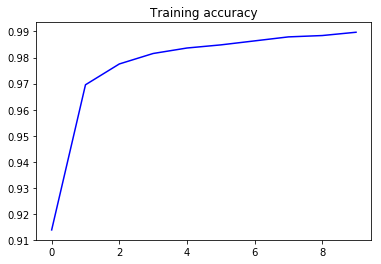

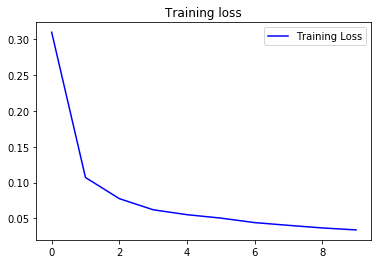

In [24]:
class EvaluateModel():
    def __init__(self,history):
        self.history = history
        self.epochs = range(len(epochs))
        
    def plot_acc_loss(self):
        
        acc = history.history['acc']
        loss = history.history['loss']

        plt.plot(epochs, acc, 'b', label='Training accuracy')
        plt.title('Training accuracy')

        plt.figure()

        plt.plot(epochs, loss, 'b', label='Training Loss')
        plt.title('Training loss')
        plt.legend()

        plt.show()

em_obj = EvaluateModel(md_obj.history)
em_obj.plot_acc_loss()